In [1]:
from luminol.anomaly_detector import AnomalyDetector
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

In [2]:
sample = pd.read_csv('../data/sample3.csv')

In [3]:
alpha = 0.3
n = sample.X.shape[0] - 1
fit = SimpleExpSmoothing(sample.X).fit(alpha)
X_clean = fit.predict(0, n)
fit = SimpleExpSmoothing(X_clean[::-1]).fit(alpha)
X_clean = fit.predict(0, n)[::-1]
X_diff = sample.X - X_clean
X_diff = X_diff / np.linalg.norm(X_diff)

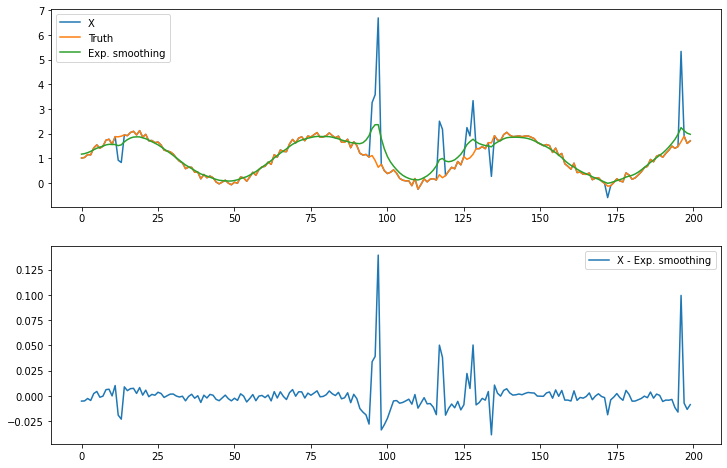

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
sample[:200].plot(ax=plt.gca())
plt.plot(X_clean[:200], label='Exp. smoothing')
plt.legend()
plt.subplot(212)
plt.plot(X_diff[:200], label='X - Exp. smoothing')
plt.legend()
plt.show()

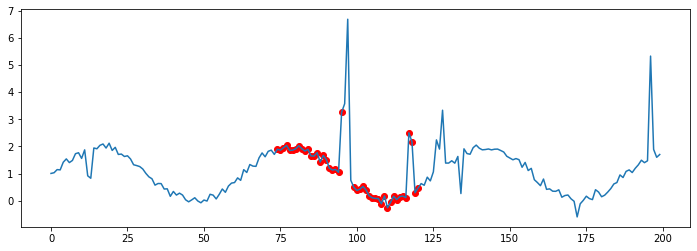

In [5]:
detector = AnomalyDetector(
    sample.X.to_dict(), 
    algorithm_name='bitmap_detector',
    score_threshold=3
)
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:200])
for a in detector.get_anomalies():
    if a.end_timestamp > 200: break
    for t in range(a.start_timestamp, a.end_timestamp):
        plt.scatter(t, sample.X[t], c='r')

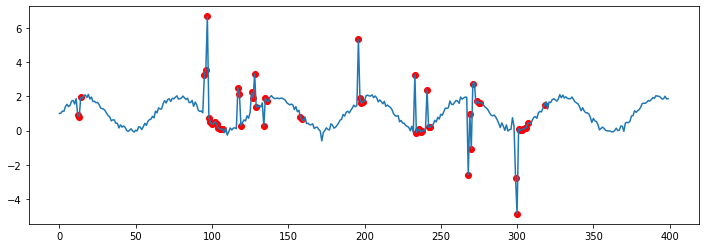

In [22]:
detector = AnomalyDetector(
    sample.X.to_dict(), 
    algorithm_name='default_detector',
    score_threshold=0.4
)
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:400])
for a in detector.get_anomalies():
    if a.start_timestamp > 400: break
    for t in range(a.start_timestamp, a.end_timestamp):
        plt.scatter(t, sample.X[t], c='r')

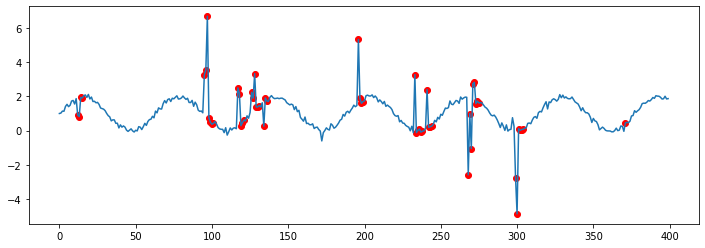

In [21]:
detector = AnomalyDetector(
    sample.X.to_dict(), 
    score_threshold=0.3,
    algorithm_name='derivative_detector',
    algorithm_params={'smoothing_factor': 0.5}
    
)
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:400])
for a in detector.get_anomalies():
    if a.start_timestamp > 400: break
    for t in range(a.start_timestamp, a.end_timestamp):
        plt.scatter(t, sample.X[t], c='r')

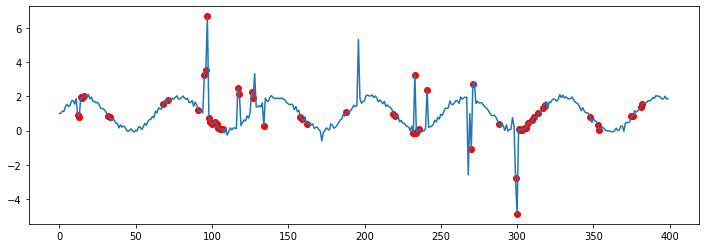

In [20]:
detector = AnomalyDetector(
    sample.X.to_dict(), 
    score_threshold=0.3,
    algorithm_name='exp_avg_detector',
    algorithm_params={'smoothing_factor': 0.2}
)
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:400])
for a in detector.get_anomalies():
    if a.start_timestamp > 400: break
    for t in range(a.start_timestamp, a.end_timestamp):
        plt.scatter(t, sample.X[t], c='r')

In [48]:
def clean(X):
    X_clean = X.copy()
    detector = AnomalyDetector(
        dict(enumerate(X_clean)),
        algorithm_name='default_detector',
        score_threshold=0.4
    )
    reversed_detector = AnomalyDetector(
        dict(enumerate(X_clean[::-1])),
        algorithm_name='default_detector',
        score_threshold=0.4
    )
    anomalies = np.array([0]*X_clean.shape[0])
    for a in detector.get_anomalies():
        for t in range(a.start_timestamp, a.end_timestamp):
            anomalies[t] += 1
    for a in reversed_detector.get_anomalies():
        for t in range(a.start_timestamp, a.end_timestamp):
            anomalies[-t+1] += 1
    X_clean[anomalies > 0] = None
    X_clean = pd.Series(X_clean).interpolate().values
    X_clean = pd.Series(X_clean).fillna(method='ffill')
    X_clean = pd.Series(X_clean).fillna(method='bfill')
    return X_clean

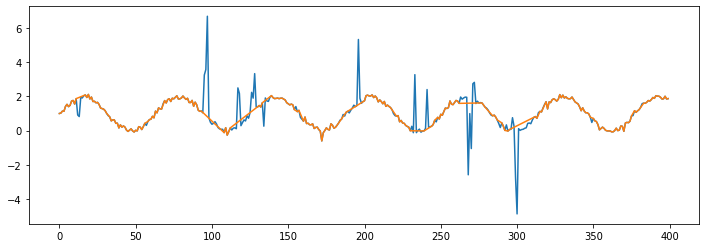

In [49]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:400])
plt.plot(clean(sample.X[:400]))

In [50]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = clean(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [51]:
report = run_tests('../data/')
report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1402144836319973
File:  ../data/sample2.csv
RMSE:  0.3697312613297166
File:  ../data/sample3.csv
RMSE:  0.20813403644155598
File:  ../data/sample4.csv
RMSE:  0.3420726769554429
File:  ../data/sample5.csv
RMSE:  0.25888292105648225
File:  ../data/sample6.csv
RMSE:  3.827201561816587
File:  ../data/sample7.csv
RMSE:  8.069944512039015
File:  ../data/sample8.csv
RMSE:  1.0408334038226084
File:  ../data/sample9.csv
RMSE:  136.4441876829584


Sample        RMSE
0  ../data/sample1.csv    0.140214
1  ../data/sample2.csv    0.369731
2  ../data/sample3.csv    0.208134
3  ../data/sample4.csv    0.342073
4  ../data/sample5.csv    0.258883
5  ../data/sample6.csv    3.827202
6  ../data/sample7.csv    8.069945
7  ../data/sample8.csv    1.040833
8  ../data/sample9.csv  136.444188

In [29]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['No', 'luminol'] + list(report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4   sample5  \
Data preparation Model                                                       
No               luminol  0.140585  0.470386  0.154878  0.512097  0.403366   

                           sample6   sample7   sample8     sample9  
Data preparation Model                                              
No               luminol  5.116254  8.934756  1.100623  134.018848

In [13]:
board.to_csv('../results/exp_smooth_luminol.csv')